In [1]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... -

 done


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/58.8 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.9 MB/s eta 0:00:00


  Preparing metadata (setup.py) ... -

 \

 done


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.2 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/109.5 kB ? eta -:--:--

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/2.2 MB ? eta -:--:--

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.4 MB/s eta 0:00:00


 done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=73a47c0df38db12ccdf73882ce5327c146b8ec3ec7834cc0507f5368abe7d88d
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf


 \

 |

 done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=62b3f52af0ebeecee076f1b1bbe70a0aef4027c718a19182d17f612ceb8c484b
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


  Attempting uninstall: timm
    Found existing installation: timm 1.0.9


    Uninstalling timm-1.0.9:


      Successfully uninstalled timm-1.0.9


In [2]:
import os
import pandas as pd
import numpy as np
import cv2
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, random_split, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torchvision.transforms import ToTensor
from PIL import Image
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision 
from torchvision import transforms
from torchinfo import summary
import timm

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, label_dir, resize=None, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.resize = resize
        self.transform = transform
        self.images = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.images)
    
    def read_mask(self, mask_path):
        image = cv2.imread(mask_path)
        image = cv2.resize(image, self.resize)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        lower1 = np.array([0, 100, 20])
        upper1 = np.array([10, 255, 255])

        lower2 = np.array([160,100,20])
        upper2 = np.array([179,255,255])
        lower_mask = cv2.inRange(image, lower1, upper1)
        upper_mask = cv2.inRange(image, lower2, upper2)
        
        red_mask = lower_mask + upper_mask;
        red_mask[red_mask != 0] = 1

        green_mask = cv2.inRange(image, (36, 25, 25), (70, 255, 255))
        green_mask[green_mask != 0] = 2

        full_mask = cv2.bitwise_or(red_mask, green_mask)
        full_mask = np.expand_dims(full_mask, axis=-1) 
        full_mask = full_mask.astype(np.uint8)
        
        return full_mask

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = cv2.imread(img_path)  # Đọc ảnh dưới dạng BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert sang RGB
        label = self.read_mask(label_path)  
        image = cv2.resize(image, self.resize)
        if self.transform:
            image = self.transform(image)
            
        return image, label

    def show_image(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = plt.imread(img_path)
        label = plt.imread(label_path)
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image)
        axs[0].set_title('Image')
        axs[1].imshow(label)
        axs[1].set_title('Label')
        plt.show()

In [4]:
image_path = []
TRAIN_DIR = '/kaggle/input/bkai-igh-neopolyp/train/train'
for root, dirs, files in os.walk(TRAIN_DIR):
    for file in files:
        path = os.path.join(root,file)
        image_path.append(path)
        
len(image_path)

1000

In [5]:
mask_path = []
TRAIN_MASK_DIR = '/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt'
for root, dirs, files in os.walk(TRAIN_MASK_DIR):
    for file in files:
        path = os.path.join(root,file)
        mask_path.append(path)
        
len(mask_path)

1000

In [6]:
dataset = CustomImageDataset(img_dir= TRAIN_DIR,
                             label_dir= TRAIN_MASK_DIR,
                             resize= (256,256),
                             transform = None)

In [7]:
import segmentation_models_pytorch as smp

model = smp.UnetPlusPlus(
    encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=3     
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

 11%|█         | 9.00M/83.3M [00:00<00:00, 94.4MB/s]

 36%|███▌      | 29.6M/83.3M [00:00<00:00, 166MB/s] 

 60%|█████▉    | 49.9M/83.3M [00:00<00:00, 187MB/s]

 90%|████████▉ | 74.6M/83.3M [00:00<00:00, 215MB/s]

100%|██████████| 83.3M/83.3M [00:00<00:00, 200MB/s]

In [8]:
batch_size = 8
images_data = []
labels_data = []
for x,y in dataset:
    images_data.append(x)
    labels_data.append(y)

In [9]:
class CustomDataset(CustomImageDataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        image = self.data[index]
        label = self.targets[index]
        if self.transform:
            transformed = self.transform(image=image, mask=label)
            image = transformed['image'].float()
            label = transformed['mask'].float()
            label = label.permute(2, 0, 1)
        return image, label
    
    def __len__(self):
        return len(self.data)

    
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),
    A.RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

train_size = int(0.9 * len(images_data))
val_size = len(images_data) - train_size
train_dataset = CustomDataset(images_data[:train_size], labels_data[:train_size], transform=train_transform)
val_dataset = CustomDataset(images_data[train_size:], labels_data[train_size:], transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
print(len(train_dataset))
print(len(val_dataset))

900
100


/tmp/ipykernel_23/2144573044.py:24: UserWarning: Argument 'eps' is not valid and will be ignored.
  A.RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),


In [10]:
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
color_dict= {0: (0, 0, 0),
             1: (255, 0, 0),
             2: (0, 255, 0)}
def mask_to_rgb(mask, color_dict):
    output = np.zeros((mask.shape[0], mask.shape[1], 3))

    for k in color_dict.keys():
        output[mask==k] = color_dict[k]

    return np.uint8(output)    

In [12]:
import torch
from torch.utils.checkpoint import checkpoint

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        # Apply checkpointing for memory-intensive blocks
        x = checkpoint(self.block1, x)
        x = checkpoint(self.block2, x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [13]:
!pip install wandb
import wandb
!wandb login 'b8c4c639822e7886cdab618e2b65e17d5d1f45fa'

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [14]:
num_epochs = 150
RESUME = 'allow'
learning_rate = 0.0001
wandb.init(
    project = "PolypSegment",
    resume=RESUME,
    config={
        "learning_rate": learning_rate,
        "epochs": num_epochs,
        "batch_size": batch_size,
    },
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: huytq225500 (huytq225500-hanoi-university-of-science-and-technology). Use `wandb login --relogin` to force relogin


wandb: Tracking run with wandb version 0.18.3


wandb: Run data is saved locally in /kaggle/working/wandb/run-20241124_041138-o9wocnfo
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run celestial-plant-29


wandb: ⭐️ View project at https://wandb.ai/huytq225500-hanoi-university-of-science-and-technology/PolypSegment


wandb: 🚀 View run at https://wandb.ai/huytq225500-hanoi-university-of-science-and-technology/PolypSegment/runs/o9wocnfo


Epoch [1/150], Loss: 0.0040581572


Save new model


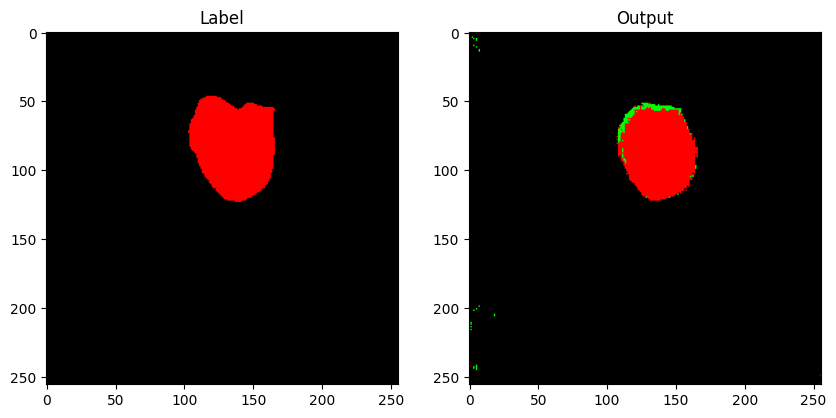

Epoch [2/150], Loss: 0.0023345947


Save new model


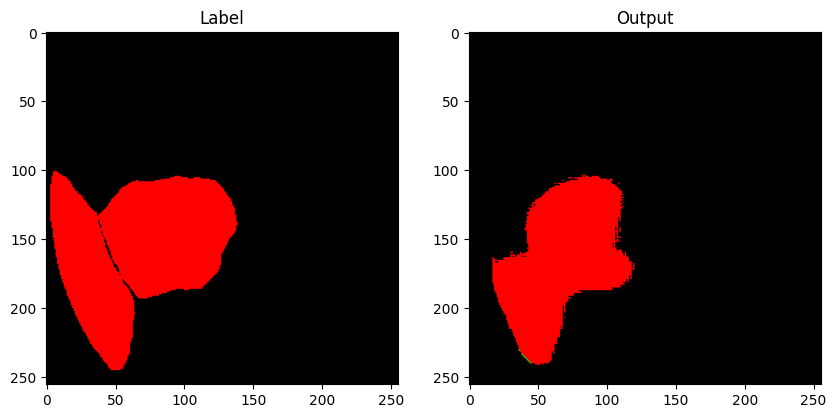

Epoch [3/150], Loss: 0.0014963129


Save new model


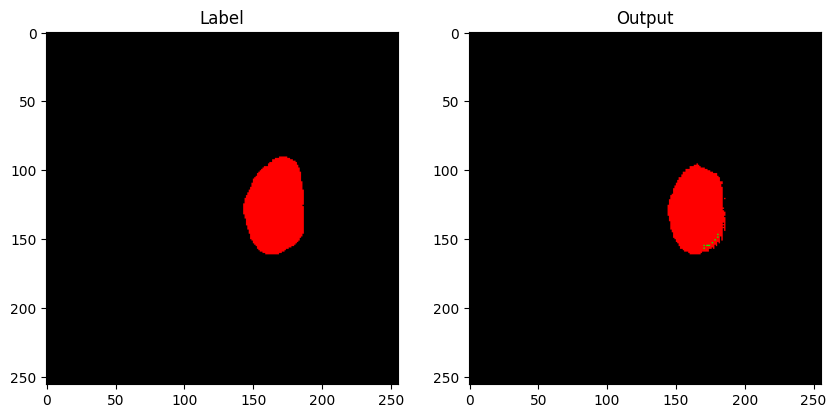

Epoch [4/150], Loss: 0.0010173879


Save new model


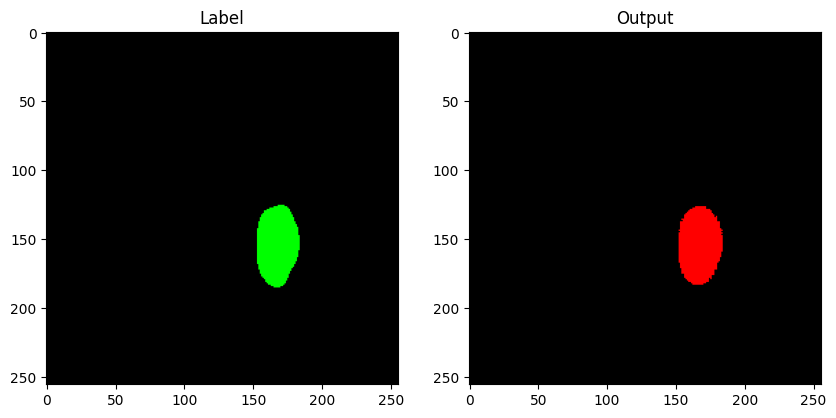

Epoch [5/150], Loss: 0.0008513296


Save new model


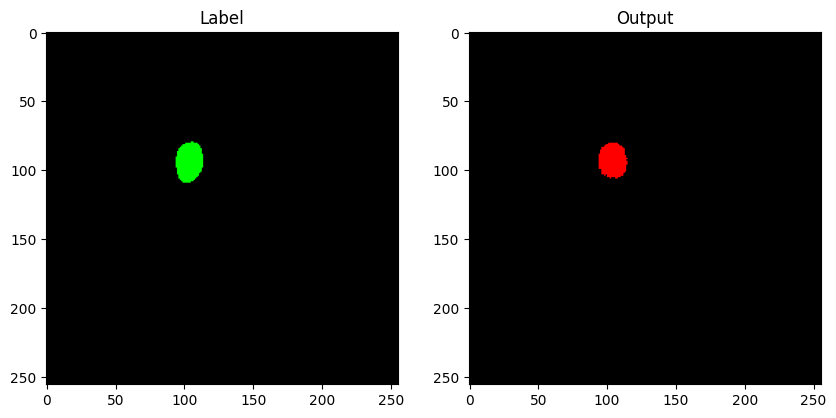

Epoch [6/150], Loss: 0.0007038868


Save new model


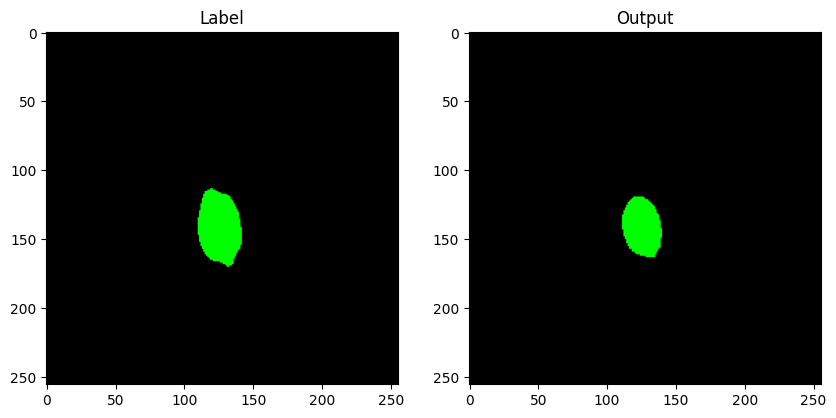

Epoch [7/150], Loss: 0.0006949214


Save new model


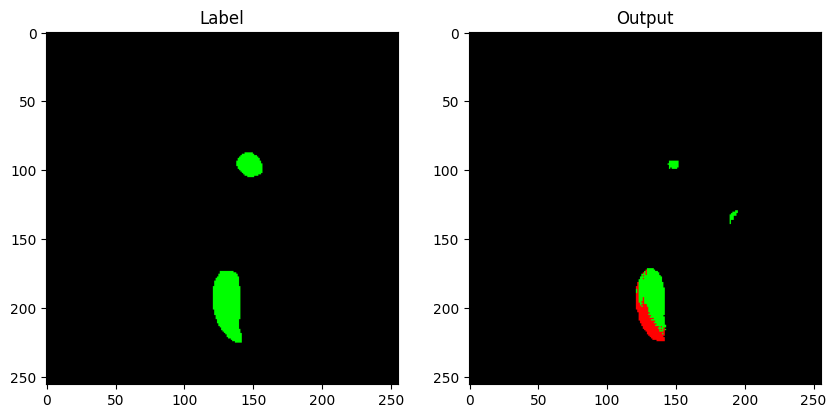

Epoch [8/150], Loss: 0.0006232611


Save new model


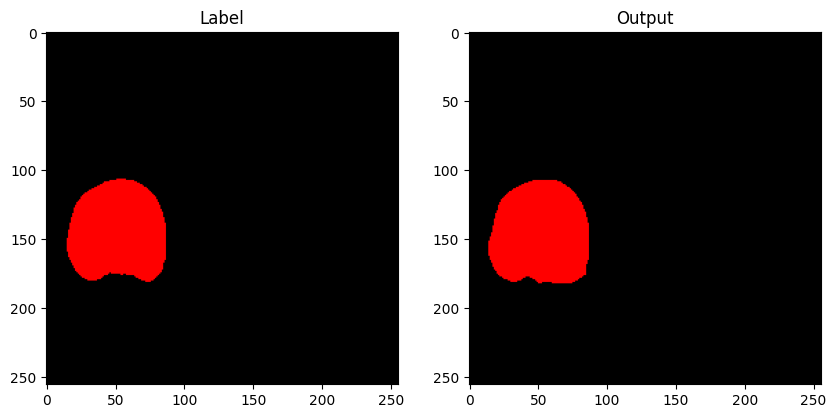

Epoch [9/150], Loss: 0.0005969192


Save new model


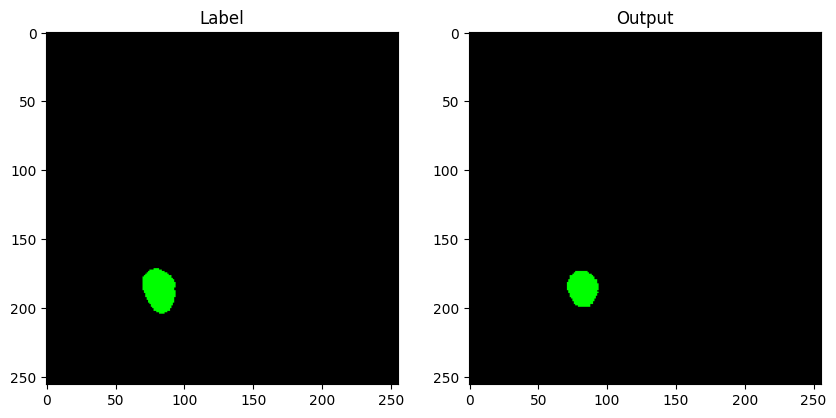

Epoch [10/150], Loss: 0.0006086743


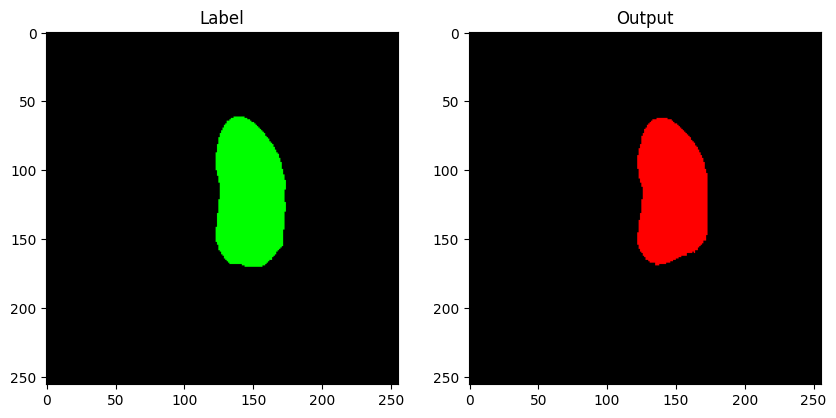

Epoch [11/150], Loss: 0.0006212756


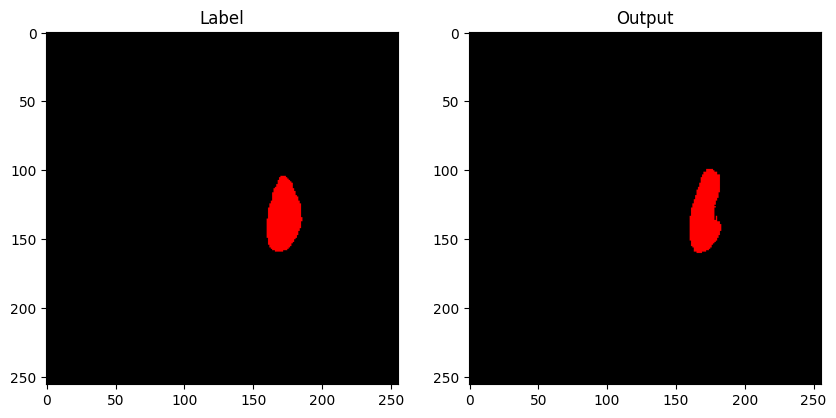

Epoch [12/150], Loss: 0.0005435268


Save new model


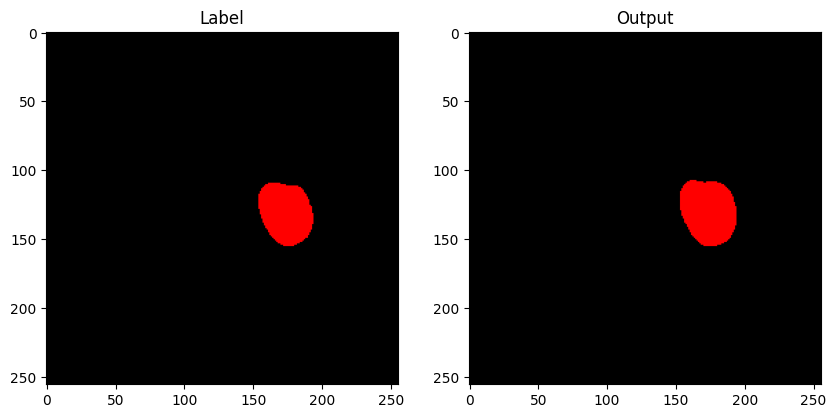

Epoch [13/150], Loss: 0.0005423693


Save new model


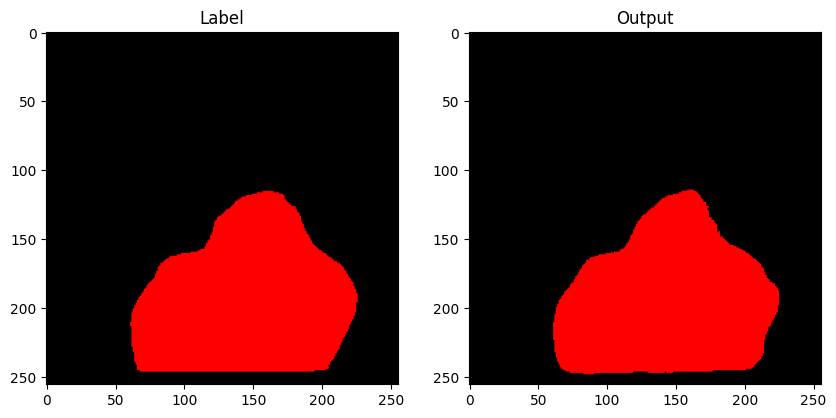

Epoch [14/150], Loss: 0.0006708991


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
best_val_loss = 999
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    train_accuracy = 0
    train_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        labels = labels.squeeze(dim=1).long()
        outputs = model(images)
    
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        pred = outputs.argmax(dim=1, keepdim=True)
        train_accuracy += pred.eq(labels.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.squeeze(dim=1).long()
            
            outputs = model(images)

            val_loss += criterion(outputs.float(),labels.long()).item()
            pred = outputs.argmax(dim = 1, keepdim = True)
            val_accuracy += pred.eq(labels.view_as(pred)).sum().item()
    val_loss /= len(val_loader.dataset)
    val_accuracy /= len(val_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss/len(val_loader):.10f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = { 
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': val_loss,
        }
        save_path = f'colorization_model.pth'
        torch.save(checkpoint, save_path)
        print('Save new model')
    wandb.log({"epoch": epoch,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
              })

    label = labels[0].cpu().numpy()
    label = mask_to_rgb(label,color_dict)
    outputs[0] = outputs[0].softmax(dim=0)
    output = outputs[0].cpu().numpy()
    output = np.argmax(output, axis=0)
    output = mask_to_rgb(output,color_dict)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(label)
    axs[0].set_title('Label')
    axs[1].imshow(output)
    axs[1].set_title('Output')
    plt.show()

In [ ]:
checkpoint = torch.load('/kaggle/working/colorization_model.pth')
model.load_state_dict(checkpoint['model'])
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
!mkdir prediction

In [ ]:
trainsize = 256
model.eval()
for i in os.listdir("/kaggle/input/bkai-igh-neopolyp/test/test"):
    img_path = os.path.join("/kaggle/input/bkai-igh-neopolyp/test/test", i)
    ori_img = cv2.imread(img_path)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    ori_w = ori_img.shape[0]
    ori_h = ori_img.shape[1]
    img = cv2.resize(ori_img, (trainsize, trainsize))
    transformed = val_transform(image=img)
    input_img = transformed["image"]
    input_img = input_img.unsqueeze(0).to(device)
    with torch.no_grad():
        output_mask = model.forward(input_img).squeeze(0).cpu().numpy().transpose(1,2,0)
    mask = cv2.resize(output_mask, (ori_h, ori_w))
    mask = np.argmax(mask, axis=2)
    mask_rgb = mask_to_rgb(mask, color_dict)
    mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite("prediction/{}".format(i), mask_rgb) 

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 225] = 255
    pixels[pixels <= 225] = 0
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    
    return rle_to_string(rle)

def rle2mask(mask_rle, shape=(3,3)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2string(dir):
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '/kaggle/working/prediction'
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']

df.to_csv(r'output.csv', index=False)
print('Done')